In [2]:
from pathlib import Path
import torch
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
tr_male = list(Path("data/train/male").glob("*.jpg"))
tr_female = list(Path("data/train/female").glob("*.jpg"))

ts_male = list(Path("data/test/male").glob("*.jpg"))
ts_female = list(Path("data/test/female").glob("*.jpg"))

len(tr_male), len(tr_female), len(ts_male), len(ts_female)

(9926, 9040, 2465, 2277)

In [4]:
from torchvision.transforms import  ToTensor, Normalize, Compose, Resize, Grayscale

custom_transform = Compose([
    Resize((128, 128)),
    Grayscale(),
    ToTensor(),
    # Normalize((0.5,), (0.5,))
])

In [5]:
from torchvision import datasets

data_folder = Path("data")
train_dir = data_folder / "train"
test_dir = data_folder / "test"

train_data = datasets.ImageFolder(root=train_dir,
                                 transform = custom_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform = custom_transform,
                                 target_transform=None)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(297, 75)

In [7]:
import torch
from torch import nn

class model_customV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.gender_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*16*16, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=output_shape)
        )
        
    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        gender = torch.sigmoid(self.gender_fc(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))
        return gender
    

modelV0 = model_customV0(input_shape=1, output_shape=1).to(device)

In [15]:
gen_loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(params = modelV0.parameters(),
                           lr = 0.003)


def lr_lambda(epoch):
    base_lr = 0.001
    factor = 0.9
    return base_lr/(1+factor*epoch)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [7]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device= device):
    model.train()

    train_loss, train_acc = 0.0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.unsqueeze(1).to(device)
        
        y_preds = model(X)

        loss = loss_fn(y_preds, y.type(torch.float))
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # y_pred_class = torch.argmax(y_preds, dim=1)
        # print(y_pred_class.shape, y.shape)
        train_acc += ((y_preds.round() == y).sum().item() / len(y))

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss.detach().cpu().numpy(), train_acc # tensor.detach() to remove the grad associated

In [8]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.unsqueeze(1).to(device)

            test_preds= model(X)
            
            loss = loss_fn(test_preds, y.type(torch.float))
            test_loss += loss

            # calculate the accuracy
            # test_pred_labels = test_preds.argmax(dim=1)
            test_acc += (test_preds.round() == y).sum().item() / len(y)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss.cpu().numpy(), test_acc

In [9]:
from tqdm.auto import tqdm

def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs = 5,
          device = device):

    results = {"train loss": [],
               "train acc": [],
               "test loss": [],
               "test acc": []}


    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"train loss {train_loss:.4f} | train acc {train_acc:.4f} | test loss {test_loss:.4f} | test acc {test_acc:.4f}")
        print("*"*14)

        # train_losses =

        results['train loss'].append(train_loss)
        results['train acc'].append(train_acc)
        results['test loss'].append(test_loss)
        results['test acc'].append(test_acc)

    return results

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 30

from timeit import default_timer as timer

start_time = timer()

model_results = train(model=modelV0.to(device),
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=gen_loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

train loss 0.2403 | train acc 0.9012 | test loss 0.4196 | test acc 0.8087
**************
train loss 0.2380 | train acc 0.9002 | test loss 0.4300 | test acc 0.8119
**************
train loss 0.2348 | train acc 0.9023 | test loss 0.4275 | test acc 0.8055
**************
train loss 0.2324 | train acc 0.9032 | test loss 0.4224 | test acc 0.8082
**************
train loss 0.2323 | train acc 0.9061 | test loss 0.4293 | test acc 0.8115
**************
train loss 0.2286 | train acc 0.9049 | test loss 0.4376 | test acc 0.8117
**************
train loss 0.2244 | train acc 0.9077 | test loss 0.4301 | test acc 0.8128
**************
train loss 0.2262 | train acc 0.9049 | test loss 0.4246 | test acc 0.8156
**************
train loss 0.2247 | train acc 0.9081 | test loss 0.4261 | test acc 0.8154
**************
train loss 0.2214 | train acc 0.9089 | test loss 0.4211 | test acc 0.8122
**************
Total training time: 263.1175196999993


In [18]:
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)
torch.save(modelV0.state_dict(), model_path / "model_gen.pth")

In [22]:
train_data.class_to_idx

{'female': 0, 'male': 1}

(-0.5, 127.5, 127.5, -0.5)

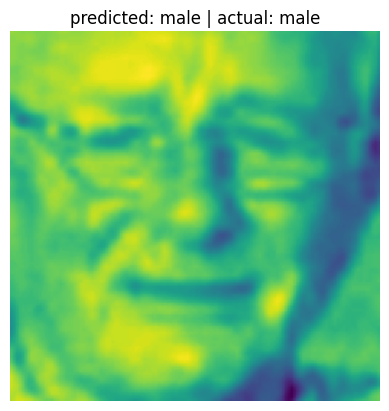

In [71]:
# load the save model and predict
from matplotlib import pyplot as plt

model_gen = model_customV0(input_shape=1, output_shape=1).to(device=device)
model_gen.load_state_dict(torch.load(Path("models") / "GENV0.pt"))

rand_idx = torch.randint(0, len(test_data), size=(1,)).item()

X, y = test_data[rand_idx]
X, y = X.unsqueeze(0).to(device), y

model_gen.eval()
with torch.inference_mode():
    y_preds = model_gen(X)
    
dct = {0 : 'female', 1 : 'male'}

y_class = dct[int(torch.round(y_preds).squeeze())]
y = dct[y]

plt.imshow(X.squeeze(0).permute(1, 2, 0).cpu())
plt.title(f"predicted: {y_class} | actual: {y}")
plt.axis(False)